# Kaggle SIIM Pneumothorax Challenge

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import gc
import cv2
import PIL
import random
import numpy as np
import inspect
import os
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pdb
from dataclasses import dataclass
from functools import partial
import datetime
from io import BytesIO
from enum import IntEnum
import sys
import neptune

from skimage.morphology import label
from sklearn.model_selection import KFold, GridSearchCV
from skorch import NeuralNet

from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.nn.functional import binary_cross_entropy_with_logits
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Sampler
from torch.optim import SGD

from fastai.vision.data import SegmentationItemList, SegmentationLabelList, ImageList, imagenet_stats
from fastai.data_block import FloatList, FloatItem, ItemList, PreProcessor
from fastai.basic_data import DatasetType, DataBunch
from fastai.basic_train import Learner
from fastai.train import GradientClipping
from fastai.callback import OptimWrapper
from fastai.core import *
from fastai.torch_core import to_device, flatten_model, ParameterModule
from fastai.layers import CrossEntropyFlat, SequentialEx
from fastai.vision.image import Image, ImageSegment, image2np, pil2tensor
from fastai.vision.transform import get_transforms
from fastai.vision.learner import unet_learner, cnn_learner
import fastai.vision.models as mod
from fastai.callbacks import SaveModelCallback, LearnerCallback
from fastai.callbacks.hooks import hook_outputs
from fastai.callbacks.tensorboard import LearnerTensorboardWriter
from fastai.metrics import accuracy
from fastprogress import fastprogress

from pathlib import Path

# IMAGE SIZES
TRAIN_SIZE = 512
MAX_SIZE = 1388
TEST_SIZE = TRAIN_SIZE
TEST_OVERLAP = 64
IMG_CHANNELS = 3

# PATHS
PROJECT_PATH = Path(
    '/work/stages/schwob/siim-pneumothorax')
DATA = PROJECT_PATH/'data'
FULL_TRAIN_PATH = DATA/'dicom-images-train'
FULL_TEST_PATH = DATA/'dicom-images-test'
FULL_SIZE_TRAIN_PATH = DATA/'train'
FULL_SIZE_TEST_PATH = DATA/'test'
TRAIN_PATH = DATA/('train'+str(TRAIN_SIZE))
TEST_PATH = DATA/('test'+str(TEST_SIZE))
MODELS_PATH = PROJECT_PATH/'models/'
SUB_PATH = PROJECT_PATH/'submissions/'
LABELS_OLD = DATA/'train-rle.csv'
LABELS = DATA/f'train-rle{TRAIN_SIZE}.csv'
LABELS_POS = DATA/'train-rle-fastai_pos.csv'
LABELS_CLASSIF = DATA/f'train-rle-clf{TRAIN_SIZE}.csv'
HYPERS_PATH = PROJECT_PATH/'submissions/hypers.csv'
LOG = Path('/work/stages/schwob/runs')

# LEARNER CONFIG
BATCH_SIZE = 2
WD = 0.
LR = 1e-4
GROUP_LIMITS = None
FREEZE_UNTIL = None
EPOCHS = 10
UNFROZE_EPOCHS = 10
PRETRAINED = True
MODEL = 'resnet34'
CLASSES = ['pneum']
ACT = 'sigmoid'

In [3]:
#from fastai.vision.models.xresnet2 import xresnet34_2, xresnet50_2, xresnet101, xresnet152

In [4]:
models = {
    'resnet34': mod.resnet34, 'resnet50': mod.resnet50,
    'resnet101': mod.resnet101, 'resnet152': mod.resnet152}
    #'xresnet34': xresnet34_2, 'xresnet50': xresnet50_2,
    #'xresnet101': xresnet101, 'xresnet152': xresnet152}

In [5]:
def delegates(to=None, keep=False):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

## Function definitions

### Data

In [6]:
def getNextFilePath(output_folder, base_name):
    highest_num = 0
    for f in output_folder.iterdir():
        if f.is_file():
            try:
                f = str(f.with_suffix('').name)
                if f.split('_')[:-1] == base_name.split('_'):
                    split = f.split('_')
                    file_num = int(split[-1])
                    if file_num > highest_num:
                        highest_num = file_num
            except ValueError:
                'The file name "%s" is incorrect. Skipping' % f

    output_file = highest_num + 1
    return output_file

In [7]:
def restruct(src, dest):
    for fn in src.glob('**/*dcm'):
        ds = pydicom.dcmread(str(fn))
        pydicom.dcmwrite(str(dest/fn.name), ds)

In [8]:
#restruct(FULL_TRAIN_PATH, TRAIN_PATH)

In [9]:
#restruct(FULL_TEST_PATH, TEST_PATH)

In [10]:
def create_train(full_size_path, path, size):
    for fn in full_size_path.glob('**/*dcm'):
        ds = pydicom.dcmread(str(fn))
        img = ds.pixel_array
        img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        ds.decompress()
        ds.PixelData = img.tobytes()
        ds.Rows, ds.Columns = img.shape
        pydicom.dcmwrite(str(path/fn.name), ds)

In [11]:
if not TRAIN_PATH.is_dir():
    TRAIN_PATH.mkdir()
    create_train(FULL_SIZE_TRAIN_PATH, TRAIN_PATH, TRAIN_SIZE)

In [12]:
if not TEST_PATH.is_dir():
    TEST_PATH.mkdir()
    create_train(FULL_SIZE_TEST_PATH, TEST_PATH, TEST_SIZE)

In [13]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel += 1

    return " ".join(rle) if rle != [] else '-1'

In [14]:
def rle2mask(rle, width, height):
    if rle == '-1':
        return np.zeros((width, height))
    mask = np.zeros(width * height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height).T

In [15]:
def absol2relat(rle):
    if str(rle) == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        if k==0:
            new_rle.append(pixels[k])
            new_rle.append(pixels[k+1])
        else:
            cur = int(pixels[k])
            prev = int(pixels[k-2])+int(pixels[k-1])
            new_rle.append(str(cur-prev))
            new_rle.append(pixels[k+1])
    return ' '.join(new_rle)

In [16]:
def relat2absol(rle):
    if str(rle) == '-1': return '-1'
    pixels = rle.split()
    new_rle = []
    cur = 0
    for k in range(0, len(pixels), 2):
        pix = pixels[k]
        cur += int(pix)
        length = pixels[k+1]
        new_rle.append(str(cur))
        new_rle.append(length)
        cur += int(length)
    return ' '.join(new_rle)

In [17]:
def merge_rles(rle1, rle2):
    if str(rle1) == str(rle2): return rle1
    i1 = 0
    i2 = 0
    rle = []
    pixels1 = relat2absol(rle1).split()
    pixels2 = relat2absol(rle2).split()
    while i1<len(pixels1) and i2<len(pixels2):
        p1 = int(pixels1[i1])
        l1 = int(pixels1[i1+1])
        p2 = int(pixels2[i2])
        l2 = int(pixels2[i2+1])
        if p1<=p2: 
            rle.append(str(p1))
            if p2<=p1+l1-1:
                rle.append(str(max(p2-p1+l2, l1)))
                i2 += 2
            else:
                rle.append(str(l1))
            i1 += 2
        else: 
            rle.append(str(p2))
            if p1<=p2+l2-1:
                rle.append(str(max(p1-p2+l1, l2)))
                i1 += 2
            else:
                rle.append(str(l2))
            i2 += 2
            
    rle += pixels1[i1:]+pixels2[i2:]
    return absol2relat(' '.join(rle))

In [18]:
def merge_doubles(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for k, id in enumerate(df['ImageId'].unique()):
        new_rle = ''
        for rle in df.loc[df['ImageId']==id, 'EncodedPixels']:
            new_rle = merge_rles(new_rle, rle)
        new_df.loc[k] = [id, new_rle]
    new_df.to_csv(new, index=False)

In [19]:
def change_csv(old, new, path, size=256):
    df = pd.read_csv(old, sep=', ')
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in tqdm(df.itertuples(), total=df.shape[0]):
        image_id = row.ImageId
        label = row.EncodedPixels
        image_id = Path(path.name)/(image_id+'.dcm')
        mask = rle2mask(label, 1024, 1024)
        mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_AREA)
        mask = (mask>127).astype(np.uint8)*255
        label = mask2rle(mask.T, size, size)
        new_df.loc[row.Index] = [image_id, label]
    new_df.to_csv(new, index=False)

In [20]:
if not LABELS.is_file():
    change_csv(LABELS_OLD, LABELS, TRAIN_PATH, size=TRAIN_SIZE)
    merge_doubles(LABELS, LABELS)

In [21]:
df = pd.read_csv(LABELS, header='infer')
df.head()

,ImageId,EncodedPixels
0,train512/1.2.276.0.7230010.3.1.4.8323329.5597....,-1
1,train512/1.2.276.0.7230010.3.1.4.8323329.12515...,-1
2,train512/1.2.276.0.7230010.3.1.4.8323329.4904....,43643 3 505 8 502 10 501 11 499 12 499 12 499 ...
3,train512/1.2.276.0.7230010.3.1.4.8323329.32579...,40738 8 501 12 497 15 495 17 493 18 490 20 489...
4,train512/1.2.276.0.7230010.3.1.4.8323329.1314....,29967 41 466 61 446 72 430 84 413 103 400 119 ...


In [22]:
df.shape

(10675, 2)

In [23]:
df['ImageId'].unique().shape

(10675,)

In [24]:
#merge_doubles(PROJECT_PATH/'data/train-rle-fastai.csv', PROJECT_PATH/'data/train-rle-fastai2.csv')

In [25]:
def keep_pos(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for row in df.itertuples():
        id = row.ImageId
        rle = row.EncodedPixels
        k = row.Index
        if rle != '-1' or random.random() <= 0.2:
            # keep all postive and only 20% of negative for segmentation
            new_df.loc[k] = [id, rle]
    new_df.to_csv(new, index=False)

In [26]:
#keep_pos(LABELS, LABELS_POS)

In [27]:
def create_classif_csv(old, new):
    df = pd.read_csv(old)
    new_df = pd.DataFrame(columns=['ImageId', 'Labels'])
    for row in df.itertuples():
        image_id = row.ImageId
        rle = row.EncodedPixels
        new_df.loc[row.Index] = [image_id, 1 if rle!='-1' else 0]
    new_df.to_csv(new, index=False)

In [28]:
#create_classif_csv(LABELS, LABELS_CLASSIF)

In [29]:
def open_image(fn):
    return pydicom.dcmread(str(fn)).pixel_array

def show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()

In [30]:
def show_dcm_info(fn):
    dataset = pydicom.dcmread(str(fn))
    print("Filename.........:", fn)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

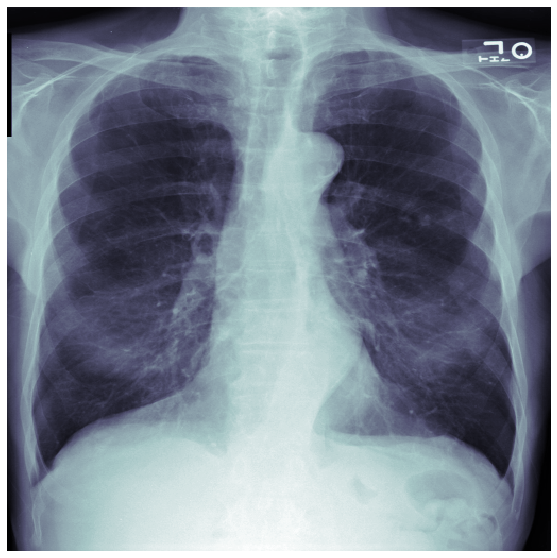

In [31]:
fn = next(TRAIN_PATH.glob('**/*.dcm'))
img = open_image(fn)
show(img)

In [32]:
show_dcm_info(fn)

Filename.........: /work/stages/schwob/siim-pneumothorax/data/train512/1.2.276.0.7230010.3.1.4.8323329.14243.1517875250.398380.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: eff52c22-7c7b-4c6f-9173-671c2ad56a1f, 
Patient id..........: eff52c22-7c7b-4c6f-9173-671c2ad56a1f
Patient's Age.......: 79
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 512 x 512, 262144 bytes
Pixel spacing....: ['0.171', '0.171']


In [33]:
img.shape

(512, 512)

In [34]:
class PneumoSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [35]:
class ImageSegmentFloat(ImageSegment):
    @property
    def data(self):
        return self.px.float()

In [36]:
class MaskList(SegmentationLabelList):
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        self.copy_new.append('train_path')
        
    def open(self, fn):
        assert self.train_path, "a path for train set must be specified"
        img_path = fn[0]
        rle = fn[1]
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegmentFloat(y/255)
    
    def analyze_pred(self, pred, thresh: float = 0.5):
        if torch.min(pred).item()<0 or torch.max(pred).item()>1:
            pred = torch.sigmoid(pred)
        return (pred > thresh).float()
    
    def reconstruct(self, t):
        return ImageSegmentFloat(t.float())

In [37]:
class SoftmaxMaskList(SegmentationLabelList):
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        self.copy_new.append('train_path')
        
    def open(self, fn):
        assert self.train_path, "a path for train set must be specified"
        img_path = fn[0]
        rle = fn[1]
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegment(y/255)

In [38]:
class PneumoClassifList(ImageList):
    def open(self, fn):
        x = open_image(fn)
        x = pil2tensor(x, np.float32)
        x = torch.cat((x, x, x))
        return Image(x/255)

In [39]:
class MultiTaskLabel(ItemBase):
    def __init__(self, cat, mask):
        self.cat = cat
        self.mask = mask
        
    @property
    def data(self):
        return [self.cat.data, self.mask.data]
            
    def __str__(self):
        return f'Category {self.cat}; {self.mask}'
    
    def show(self, *args, **kwargs):
        return self.mask.show(*args, **kwargs)
        
    def apply_tfms(self, *args, **kwargs):
        self.mask = self.mask.apply_tfms(*args, **kwargs)
        return self

In [40]:
class MultiTaskProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes)
        self.state_attrs,self.warns = ['classes'],[]

    def create_classes(self, classes):
        self.classes = classes
        if classes is not None: self.c2i = {v:k for k,v in enumerate(classes)}

    def generate_classes(self, items):
        "Generate classes from `items` by taking the sorted unique values."
        return uniqueify(items, sort=True)

    def process(self, ds):
        if self.classes is None: self.create_classes(self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        ds.c = len(self.classes)

    def __getstate__(self): return {n:getattr(self,n) for n in self.state_attrs}
    def __setstate__(self, state:dict):
        self.create_classes(state['classes'])
        self.state_attrs = state.keys()
        for n in state.keys():
            if n!='classes': setattr(self, n, state[n])

In [41]:
class MultiTaskLabelList(SegmentationLabelList):
    _bunch,_square_show,_square_show_res = DataBunch,True,True
    _processor = MultiTaskProcessor
    def __init__(self, *args, train_path=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_path = train_path
        self.copy_new.append('train_path')
        
    def get(self, i):
        img_path, rle = self.items[i]
        if str(rle) == '-1':
            cat = 0
        else:
            cat = 1
        mask = self.open(img_path, rle)
        return MultiTaskLabel(Category(cat, self.classes[cat]), mask)
    
    def open(self, img_path, rle):
        assert self.train_path, "a path for train set must be specified"
        h, w = open_image(self.train_path/img_path).shape
        y = rle2mask(rle, w, h)
        y = pil2tensor(y, np.float32)
        return ImageSegment(y/255)
    
    def analyze_pred(self, t, thr=0.5):
        cat, mask = t
        mask = (mask[1] > thr).long().unsqueeze(0)
        cat = (cat[1] > thr).long()
        return (cat, mask)
    
    def reconstruct(self, t):
        cat, mask = t
        return MultiTaskLabel(Category(cat, self.classes[cat]), ImageSegment(mask))

In [42]:
class MultiTaskList(PneumoSegmentationList):
    _bunch, _label_cls = DataBunch, MultiTaskLabelList

In [43]:
def get_weights(train_list):
    df = train_list.inner_df
    n_tot = df.shape[0]
    df = df.reset_index()
    class_weights = []
    weights = np.zeros(n_tot)    
    for c in train_list.classes:
        w = df.loc[df['Labels']==c].shape[0]/n_tot
        w = (1-w)/(train_list.c-1)
        class_weights.append(w)
        weights[df.loc[df['Labels']==c].index.values] = w
    return weights, class_weights

In [44]:
def create_sampler(train_list, class_weights):
    weights = [class_weights[c.data] for _, c in train_list.train]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

In [45]:
def load_data(path, bs=8, train_size=256):
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
                  transform(get_transforms(do_flip=False), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0).
                  normalize(imagenet_stats))
    return train_list

In [46]:
def load_data_softmax(path, bs=8, train_size=256):
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['bg', 'pneum'], label_cls=SoftmaxMaskList, train_path=path.parent).
                  transform(get_transforms(do_flip=False), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0).
                  normalize(imagenet_stats))
    return train_list

In [47]:
def load_data_classif(path, bs=8, train_size=256):
    train_list = (PneumoClassifList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df().
                  transform(get_transforms(do_flip=False), size=train_size).
                  databunch(bs=bs, num_workers=0).
                  normalize(imagenet_stats))
    
    return train_list

In [48]:
def load_data_mtl(path, bs=8, train_size=256):
    train_list = (MultiTaskList.
                  from_csv(path.parent, path.name).
                  split_by_rand_pct(valid_pct=0.2).
                  label_from_df(cols=[0, 1], classes=['bg', 'pneum'], label_cls=MultiTaskLabelList, train_path=path.parent).
                  transform(get_transforms(do_flip=False), size=train_size, tfm_y=True).
                  databunch(bs=bs, num_workers=0))
    return train_list

In [49]:
def get_weights_sampler(db, beta=0.8):
    df = db.train_ds.inner_df
    n_tot = df.shape[0]
    df = df.reset_index()
    weights = np.zeros(n_tot)
    weights[df.loc[df['EncodedPixels']=='-1'].index.values] = 1-beta
    weights[df.loc[df['EncodedPixels']!='-1'].index.values] = beta
    return weights

### Models

In [50]:
def forward(self, x):
        res = x
        orig = x.orig
        for l in self:
            res.orig = orig
            nres = l(res)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            res.orig = None
            res = nres
        res.orig = orig
        return res
nn.ModuleList.forward = forward

In [51]:
class MultiTaskModel(nn.Module):
    def __init__(self, base, heads):
        super().__init__()
        self.base = base
        self.heads = nn.ModuleList(heads)
        self.log_vars = ParameterModule(nn.Parameter(torch.zeros(len(self.heads))))

    def forward(self, x):
        res = x
        res.orig = x
        nres = self.base(res)
        res.orig = None
        res = nres
        all_res = []
        for head in self.heads:  
            res.orig = x
            nres = head(res)
            all_res.append(nres)
            res.orig = None
        return all_res

    def __getitem__(self,i): return self.heads[i]
    def append(self,l): return self.heads.append(l)
    def extend(self,l): return self.heads.extend(l)
    def insert(self,i,l): return self.heads.insert(i,l)

In [52]:
def multi_task_unet_learner(*args, **kwargs):
    unet_learn = unet_learner(*args, **kwargs)
    sfs_idxs = unet_learn.model.sfs_idxs
    cnn_learn = cnn_learner(*args, **kwargs)
    base = unet_learn.model[0]
    unet_head = unet_learn.model[1:]
    hooks = hook_outputs([base[i] for i in sfs_idxs])
    for block, hook in zip(unet_head[3:7], hooks):
        block.hook = hook
    heads = [cnn_learn.model[1:], unet_head]
    unet_learn.model = MultiTaskModel(base, heads).to(unet_learn.data.device)
    lg = unet_learn.layer_groups
    lg[2] = nn.Sequential(*list(lg[2]), *flatten_model(heads[0]), unet_learn.model.log_vars)
    unet_learn.layer_groups = lg
    unet_learn.create_opt(slice(1e-3))
    return unet_learn

### Metrics

In [53]:
def dice(input, target, smooth=1., reduction='mean', thr=None, activ='softmax', **kwargs):
    act = nn.Softmax(dim=1) if activ=='softmax' else nn.Sigmoid()
    iflat = act(input)
    if activ=='softmax':
        iflat = iflat[:, 1]
    iflat = iflat.view(input.size(0),  -1).float()
    tflat = target.view(target.size(0), -1).float()
    if thr is not None:
        iflat = (iflat > thr).float()
    intersection = (iflat * tflat).sum(-1)
    dice = (2. * intersection + smooth)/((iflat + tflat).sum(-1) + smooth)
    if reduction=='mean':
        return dice.mean()
    elif reduction=='sum':
        return dice.sum()
    else:
        return dice

In [54]:
def mtl_metric(metric, dim=0):
    def new_metric(input, *targets, **kwargs):
        return metric(input[dim], targets[dim], **kwargs)
    new_metric.__name__ = metric.__name__
    return new_metric

In [55]:
def average_mtl_metric(metrics, dims):
    def new_metric(input, *targets, **kwargs):
        scores = []
        for metric, dim in zip(metrics, dims):
            scores.append(metric(input[dim], targets[dim], **kwargs))
        return sum(scores)/len(scores)
    new_metric.__name__ = '_'.join(metric.__name__ for metric in metrics)
    return new_metric    

In [56]:
def mtl_scores(learner, thrs, ds_type=DatasetType.Valid):
    dices = torch.zeros(len(thrs))
    dices_pos = torch.zeros(len(thrs))
    fp_rates = torch.zeros(len(thrs))
    fn_rates = torch.zeros(len(thrs))
    dl = learner.data.dl(ds_type)
    pos_count = 0
    for x, targs in tqdm(dl):
        y_cat, y_mask = learner.pred_batch(batch=(x, targs))
        y_cat = nn.Softmax(dim=1)(y_cat.cuda())
        y_mask = nn.Softmax(dim=1)(y_mask.cuda())
        n = y_mask.shape[0]
        targ_cats, targ_masks = targs
        targ_masks = targ_masks.float().view(n, -1)
        targ_cats = targ_cats.float()
        y_mask = y_mask[:, 1]
        y_cat = y_cat[:, 1]
        y_mask = y_mask.view(n, -1)
        y_mask[y_mask.sum(-1) < 5e-3*TEST_SIZE**2] = 0.0
        pos_idxs = (targ_masks.max(dim=1).values == 1).nonzero().squeeze(1)
        targ_masks_pos = targ_masks[pos_idxs]
        y_mask_pos = y_mask[pos_idxs]
        pos_count += pos_idxs.size(0)
        for k, thr in enumerate(thrs):
            pred_masks = (y_mask>thr).float()
            intersect = (pred_masks * targ_masks).sum(-1).float()
            union = (pred_masks+targ_masks).sum(-1).float()
            u0 = union==0
            intersect[u0] = 1
            union[u0] = 2
            dices[k] += (2. * intersect / union).mean().cpu()
            
            if pos_idxs.size(0) > 0:
                pred_masks_pos = (y_mask_pos>thr).float()
                intersect = (pred_masks_pos * targ_masks_pos).sum(-1).float()
                union = (pred_masks_pos+targ_masks_pos).sum(-1).float()
                dices_pos[k] += (2. * intersect / union).mean().cpu()
            
            pred_cats = (y_cat>thr).float()
            fp_rate = ((((1-targ_cats)*pred_cats).sum()+1e-7)/((1-targ_cats).sum()+1e-7)).cpu()
            fn_rate = (((targ_cats*(1-pred_cats)).sum()+1e-7)/(targ_cats.sum()+1e-7)).cpu()
            fp_rates[k] += fp_rate
            fn_rates[k] += fn_rate
    return [dices_pos.numpy()/pos_count]+list(map(lambda x: x.numpy()/len(dl), [dices, fp_rates, fn_rates]))

In [57]:
def dice_overall(learner, thrs, ds_type=DatasetType.Valid):
    dices = torch.zeros(len(thrs))
    dl = learner.data.dl(ds_type)
    for x, targs in tqdm(dl):
        y_pred = learner.pred_batch(batch=(x, targs)).cuda()
        n = y_pred.shape[0]
        targs = targs.float().view(n, -1)
        y_pred = y_pred[:, 1]
        y_pred[y_pred.view(n,-1).sum(-1) < 5e-3*TEST_SIZE**2,...] = 0.0
        for k, thr in enumerate(thrs):
            preds = (y_pred>thr).float().view(n, -1)            
            intersect = (preds * targs).sum(-1).float()
            union = (preds+targs).sum(-1).float()
            u0 = union==0
            intersect[u0] = 1
            union[u0] = 2
            dices[k] += (2. * intersect / union).mean().cpu()
    return dices/len(dl)

### Losses

In [58]:
@delegates(dice)
def dice_loss(input, target, **kwargs):
    return 1-dice(input, target, thr=None, **kwargs)

In [59]:
def bce_loss(input, target, reduction='mean', beta=0.5, eps=1e-7, **kwargs):
    n = input.size(0)
    iflat = torch.sigmoid(input).view(n, -1).clamp(eps, 1-eps)
    tflat = target.view(n, -1)
    bce = -(beta*tflat*iflat.log()+(1-beta)*(1-tflat)*(1-iflat).log()).mean(-1)
    if torch.isnan(bce.mean()) or torch.isinf(bce.mean()):
        pdb.set_trace()
    if reduction == 'mean':
        return bce.mean()
    elif reduction == 'sum':
        return bce.sum()
    else:
        return bce

In [60]:
def focal_loss(input, target, reduction='mean', beta=0.5, gamma=2., eps=1e-7, **kwargs):
    n = input.size(0)
    iflat = torch.sigmoid(input).view(n, -1).clamp(eps, 1-eps)
    tflat = target.view(n, -1)
    focal = -(beta*tflat*(1-iflat).pow(gamma)*iflat.log()+
             (1-beta)*(1-tflat)*iflat.pow(gamma)*(1-iflat).log()).mean(-1)
    if torch.isnan(focal.mean()) or torch.isinf(focal.mean()):
        pdb.set_trace()
    if reduction == 'mean':
        return focal.mean()
    elif reduction == 'sum':
        return focal.sum()
    else:
        return focal    

In [61]:
@delegates(dice_loss)
def bce_dice_loss(input, target, a=0.5, b=0.5, smooth=1., beta=0.5, reduction='mean', **kwargs):
    dice =  dice_loss(input, target, smooth=smooth, reduction=reduction, **kwargs)
    bce = bce_loss(input, target, beta=beta, reduction=reduction, **kwargs)
    return a*bce+b*dice

In [62]:
class MTLLoss(nn.Module):    
    def __init__(self, *loss_funcs):
        super().__init__()
        self.losses = []
        self.loss_funcs = loss_funcs
        
    def forward(self, inputs, *targets):
        self.losses = [func(input, target) for func, input, target in zip(self.loss_funcs, inputs, targets)]
        return sum(self.losses)/len(self.losses)

In [63]:
@dataclass
class URLoss():
    func : nn.Module
    loss : torch.Tensor = None
    reduction : str = 'mean'
    
    def __post_init__(self):
        self.func.reduction = 'none'
        
    def __call__(self, input, target):
        self.func.reduction = 'none'
        self.loss = self.func(input, target)
        if self.reduction == 'mean': return self.loss.mean()
        elif self.reduction == 'sum': return self.loss.sum()
        else: return self.loss
        
    def __getattr__(self, name):
        return getattr(self.func, name)
    
    def __setstate__(self, data): 
        self.__dict__.update(data)

In [64]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean', smooth_num=True):
        super().__init__()
        self.smooth = smooth
        self.reduction = reduction
        self.smooth_num = smooth_num
    
    def forward(self, input, target):
        return dice_loss(input, target, smooth=self.smooth, reduction=self.reduction, smooth_num=self.smooth_num)

In [65]:
class BCELoss(nn.Module):
    def __init__(self, beta=0.5, reduction='mean'):
        super().__init__()
        self.beta = beta
        self.reduction = reduction
        
    def forward(self, input, target):
        return bce_loss(input, target, reduction=self.reduction, beta=self.beta)

In [66]:
class BCEDiceLoss(nn.Module):
    def __init__(self, a=0.5, b=0.5, smooth=1., beta=0.5, reduction='mean', smooth_num=True):
        super().__init__()
        self.a = a
        self.b = b
        self.smooth = smooth
        self.beta = beta
        self.reduction = reduction
        self.smooth_num = smooth_num
        
    def forward(self, input, target, **kwargs):
        return bce_dice_loss(input, target, a=self.a, b=self.b, smooth=self.smooth, beta=self.beta,
                             reduction=self.reduction, smooth_num=self.smooth_num, **kwargs)

In [67]:
class FocalDiceLoss(nn.Module):
    def __init__(self, a=0.5, b=0.5, smooth=1., beta=0.5, gamma=2., reduction='mean', smooth_num=True):
        super().__init__()
        self.a = a
        self.b = b
        self.smooth = smooth
        self.beta = beta
        self.gamma = gamma
        self.reduction = reduction
        self.smooth_num = smooth_num
        
    def forward(self, input, target, **kwargs):
        focal = focal_loss(input, target, beta=self.beta, gamma=self.gamma, reduction=self.reduction, **kwargs)
        dice = dice_loss(input, target, smooth=self.smooth, reduction=self.reduction,
                         smooth_num=self.smooth_num, **kwargs)
        return self.a*focal+self.b*dice

### Callbacks

In [68]:
from itertools import tee
def new_iter(self):
    dl = iter(self.dl)
    dl.sampler_iter, self.sampler_iter = tee(dl.sampler_iter)
    for b in dl:
        yield self.proc_batch(b)

from fastai.basic_data import DeviceDataLoader
DeviceDataLoader.__iter__= new_iter

In [69]:
class RandomSampler(Sampler):
    def __init__(self, num_samples, weights = None):
        self.weights = weights.float() if weights is not None else torch.ones(num_samples).float()
        self.num_samples = num_samples

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, True).tolist())

    def __len__(self):
        return self.num_samples

In [70]:
class UpdateSamplerCallback(LearnerCallback):
    _order = 0
    def __init__(self, *args, do_update=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights = self.learn.data.train_dl.sampler.weights.clone()
        self.to_update = torch.ones_like(self.weights, dtype=torch.bool)
        self.do_update = do_update
    
    def on_epoch_begin(self, **kwargs):
        if self.do_update:
            sampler = self.learn.data.train_dl.sampler
            sampler.weights = self.weights.clone()
        
    def on_epoch_end(self, **kwargs):
        self.weights[self.to_update] *= 1.5
        self.weights = torch.clamp(sampler.weights, 0., 1.)
        self.to_update = torch.ones_like(self.weights, dtype=torch.bool)
        
    def on_backward_begin(self, **kwargs):
        loss = self.learn.loss_func.loss.float().detach()
        n = min(learner.data.batch_size, loss.size(0))
        loss = loss.view(n, -1)
        loss = loss.mean(-1)
        dl = self.learn.data.train_dl
        idxs = next(dl.sampler_iter)
        self.weights[idxs] = 1-torch.exp(-loss.cpu())
        self.to_update[idxs] = False

In [71]:
class AccumulateOptimWrapper(OptimWrapper):
    def step(self):           pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
def acc_create_opt(self, lr, wd=0.):
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = AccumulateOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                         wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = acc_create_opt   

In [72]:
@dataclass
class AccumulateStep(LearnerCallback):
    """
    Does accumlated step every nth step by accumulating gradients
    """
    def __init__(self, learn:Learner, n_step:int = 1):
        super().__init__(learn)
        self.n_step = n_step
        self.acc_batches = 0

    def on_epoch_begin(self, **kwargs):
        "init samples and batches, change optimizer"
        self.acc_batches = 0
        
    def on_batch_begin(self, last_input, last_target, **kwargs):
        "accumulate samples and batches"
        self.acc_batches += 1
        
    def on_backward_end(self, **kwargs):
        "step if number of desired batches accumulated, reset samples"
        if (self.acc_batches % self.n_step) == self.n_step - 1:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
    
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0
    
    def on_epoch_end(self, **kwargs):
        "step the rest of the accumulated grads"
        if self.acc_batches > 0:
            for p in (self.learn.model.parameters()):
                if p.requires_grad: p.grad.div_(self.acc_batches)
            self.learn.opt.real_step()
            self.learn.opt.real_zero_grad()
            self.acc_batches = 0

In [73]:
class MonitorGrad(LearnerCallback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.grads = []

    def on_backward_end(self, **kwargs):
        grads = []
        for p in self.learn.model.parameters():
            if p.grad is not None:
                grad = p.grad.float().mean()
                grads.append(grad.item())
        mean_grad = sum(grads)/len(grads)
        self.grads.append(mean_grad)

In [74]:
class MTLLossCallback(LearnerCallback):
    _order = -100
    
    def on_loss_end(self, **kwargs):
        losses = self.learn.loss_func.losses
        losses = [loss*torch.exp(-log_var)+log_var/2 for log_var, loss in zip(self.learn.model.log_vars.val, losses)]
        return {'last_loss': sum(losses)/len(losses)}

In [75]:
class NeptuneCallback(LearnerCallback):
    _order = 500

    def __init__(self, learner, project, name='Untitled', params={}, **kwargs):
        super().__init__(learner, **kwargs)
        self.exp = project.create_experiment(name=name, params=params)

    def on_backward_begin(self, last_loss, iteration, **kwargs):
        self.exp.send_metric('train_loss', iteration, last_loss)

    def on_epoch_end(self, last_metrics, epoch, **kwargs):
        metric_names = [met.__name__ for met in self.learn.metrics]
        for m, v in zip(metric_names, last_metrics[1:]):
            self.exp.send_metric(m, epoch, v)

    def on_train_end(self, **kwargs):
        self.exp.stop()

In [76]:
def set_BN_momentum(model,momentum=0.05):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum

In [77]:
def on_backward_end(self, **kwargs):
    "Clip the gradient before the optimizer step."
    if self.clip: nn.utils.clip_grad_value_(self.learn.model.parameters(), self.clip)
        
#GradientClipping.on_backward_end = on_backward_end

### Submission

In [78]:
def hyper_csv(path, **kwargs):
    if path.is_file():
        old_df = pd.read_csv(path)
        old_columns = old_df.columns.values
        new_columns = list(kwargs)
        columns = np.union1d(old_columns, new_columns)
        df = pd.DataFrame(columns=columns)
        df = df.append([kwargs])
        df = pd.merge(old_df, df, how='outer')
    else:
        df = pd.DataFrame([kwargs])
    df.to_csv(path, index=False)
    return df

In [79]:
def get_best_thr(learner, plot=True):
    thrs = np.arange(0.1, 1, 0.01)
    dices = dice_overall(learner, thrs)
    dices = dices.numpy()
    best_dice = dices.max()
    best_thr = thrs[dices.argmax()]
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thrs, dices)
        plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
        plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14)
        plt.show()
    
    return best_thr

In [80]:
def get_best_thr_clf(learner, plot=True):
    thrs = np.arange(0.1, 1, 0.01)
    preds, gt = learner.get_preds()
    gt = gt.float()
    preds = preds[:, 1]
    fp_rates = []
    fn_rates = []
    scores= []
    best_score = 10000
    best_thr = 0.5
    for thr in thrs:
        fp_rate = (((1-gt)*(preds>thr).float()).sum()+1e-7)/((1-gt).sum()+1e-7)
        fp_rates.append(fp_rate)
        fn_rate = ((gt*(1-(preds>thr).float())).sum()+1e-7)/(gt.sum()+1e-7)
        fn_rates.append(fn_rate)
        score = fp_rate+fn_rate
        scores.append(score)
        if score < best_score:
            best_thr = thr
            best_score = score
    fp_rates = np.array(fp_rates)
    fn_rates = np.array(fn_rates)
    scores = np.array(scores)
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thrs, fp_rates, label='fp rate')
        plt.plot(thrs, fn_rates, label='fn rate')
        plt.plot(thrs, scores, label='fp rate + fn rate')
        plt.vlines(x=best_thr, ymin=fp_rates.min(), ymax=fp_rates.max())
        plt.legend()
        plt.show()    
        
    return best_thr

In [81]:
def get_best_thrs_mtl(learner, plot=True, a=0.8):
    thrs = np.arange(0.1, 1, 0.01)
    dices_pos, dices, fp_rates, fn_rates = mtl_scores(learner, thrs)
    dice_scores = a*dices_pos+(1-a)*dices
    scores = a*fp_rates+(1-a)*fn_rates
    best_dice = (dice_scores).max()
    best_thr = thrs[(dice_scores).argmax()]
    best_score = scores.min()
    best_thr_clf = thrs[scores.argmin()]
    if plot:
        plt.figure(figsize=(8,4))
        plt.plot(thrs, dice_scores, label='dice')
        plt.vlines(x=best_thr, ymin=dice_scores.min(), ymax=dice_scores.max())
        plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14)
        
        plt.plot(thrs, fp_rates, label='fp rate')
        plt.plot(thrs, fn_rates, label='fn rate')
        plt.plot(thrs, scores, label=f'{a}*fp rate + {1-a}*fn rate')
        plt.vlines(x=best_thr_clf, ymin=0, ymax=scores.min())
        plt.text(best_thr_clf+0.03, best_score-0.01, f'FP + FN = {best_score:.3f}', fontsize=14)
        
        plt.legend()
        plt.show()  
    return best_thr, best_thr_clf

In [82]:
def create_submission(learner, path, thr=0.5):
    sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for x, y in tqdm(learner.data.test_dl):
        preds = learner.pred_batch(batch=(x, y))
        preds = preds[:, 1]
        preds[preds.view(preds.shape[0],-1).sum(-1) < 5e-3*TEST_SIZE**2,...] = 0.0
        idxs = next(learner.data.test_dl.sampler_iter)
        for k, pred in enumerate(preds.squeeze(1)):
            y = pred.numpy()
            if y.shape[-1] != 1024:
                y = cv2.resize(y, (1024, 1024), interpolation=cv2.INTER_AREA)
            y = (y > thr).astype(np.uint8)*255
            id = learner.data.test_ds.items[idxs[k]].with_suffix('').name
            rle = mask2rle(y.T, *y.shape[-2:])
            sub.loc[idxs[k]] = [id, rle]
    sub.to_csv(path, index=False)
    return sub

In [83]:
def create_submission_with_clf(learner, path, ids, thr=0.5):
    sub_df = create_submission(learner, path, thr=thr)
    n = sub_df.shape[0]
    for k, id in enumerate(ids):
        sub_df.loc[n+k] = [id.with_suffix('').name, '-1']
    sub_df.to_csv(path, index=False)
    return sub_df

In [84]:
def create_submission_mtl(learner, path, thr=0.5, thr_clf=0.5):
    sub = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])
    for x, y in tqdm(learner.data.test_dl):
        y_cat, y_mask = learner.pred_batch(batch=(x, y))
        y_cat = nn.Softmax(dim=1)(y_cat)[:, 1]
        y_mask = nn.Softmax(dim=1)(y_mask)[:, 1]
        y_mask[y_mask.view(y_mask.shape[0],-1).sum(-1) < 1e-3*TEST_SIZE**2,...] = 0.0
        idxs = next(learner.data.test_dl.sampler_iter)
        for k, (cat, mask) in enumerate(zip(y_cat, y_mask.squeeze(1))):
            if cat < thr_clf:
                rle = '-1'
            else:
                mask = (mask>thr).float().numpy()
                mask = cv2.resize(mask, (1024, 1024), interpolation=cv2.INTER_AREA)
                mask = (mask>0.5).astype(np.uint8)*255
                rle = mask2rle(mask.T, *mask.shape[-2:])
            id = learner.data.test_ds.items[idxs[k]].with_suffix('').name
            sub.loc[idxs[k]] = [id, rle]
    sub.to_csv(path, index=False)
    return sub

## Param Find

In [ ]:
#sys.stdout = open('/dev/stdout', 'w')

In [ ]:
"""db = load_data(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)
k = 0
for LR in [1e-5, 1e-4, 1e-3, 1e-2]:
    for WD in [1e-4, 1e-3, 1e-2, 1e-1]:
        for beta in [0.3, 0.4, 0.5, 0.6, 0.7]:
            for loss_func in [BCELoss(beta=beta), BCEDiceLoss(beta=beta, smooth_num=False), BCEDiceLoss(beta=beta)]:
                for weight_init in [0.5, 0.6, 0.7, 0.8]:
                    weights = get_weights_sampler(db, beta=weight_init)

                    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                                           loss_func=URLoss(loss_func),
                                           wd=WD, model_dir=MODELS_PATH, metrics=[dice])

                    sampler = RandomSampler(len(db.train_ds), weights=torch.tensor(weights))

                    learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

                    set_BN_momentum(learner.model)

                    learner.fit_one_cycle(
                        1, slice(LR), 
                        callbacks=[AccumulateStep(learner, 64//BATCH_SIZE),
                                   MonitorGrad(learner)])

                    mean_grad = np.sum(np.absolute(learner.monitor_grad.grads[:50]))/50

                    valid_preds, valid_gt = learner.get_preds(DatasetType.Valid, activ=torch.sigmoid)

                    valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 5e-3*TRAIN_SIZE**2,...] = 0.0

                    thr = get_best_thr(valid_preds, valid_gt, plot=False)

                    val_dice = dice_overall(valid_preds, valid_gt, thr=thr)
                    
                    add_loss = '1' if isinstance(loss_func, BCEDiceLoss) and loss_func.smooth_num else ''

                    hypers = {'size': TRAIN_SIZE, 'lr': LR, 'wd': WD, 'bs': BATCH_SIZE,
                              'loss': type(loss_func).__name__+add_loss, 'beta': beta,
                              'weight_init': weight_init, 'thr': thr, 'mean_grad': mean_grad,
                              'dice': val_dice.item()}
                    print(k, hypers)
                    k += 1
                    hyper_csv(HYPERS_PATH, **hypers)"""

"db = load_data(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)\nk = 0\nfor LR in [1e-5, 1e-4, 1e-3, 1e-2]:\n    for WD in [1e-4, 1e-3, 1e-2, 1e-1]:\n        for beta in [0.3, 0.4, 0.5, 0.6, 0.7]:\n            for loss_func in [BCELoss(beta=beta), BCEDiceLoss(beta=beta, smooth_num=False), BCEDiceLoss(beta=beta)]:\n                for weight_init in [0.5, 0.6, 0.7, 0.8]:\n                    weights = get_weights_sampler(db, beta=weight_init)\n\n                    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,\n                                           loss_func=URLoss(loss_func),\n                                           wd=WD, model_dir=MODELS_PATH, metrics=[dice])\n\n                    sampler = RandomSampler(len(db.train_ds), weights=torch.tensor(weights))\n\n                    learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)\n\n                    set_BN_momentum(learner.model)\n\n                    learner.fit_one_cycle(\n             

In [ ]:
#hyper_df = pd.read_csv(HYPERS_PATH)
#hyper_df.head()

## Training

### Frozen training

In [108]:
db = load_data_softmax(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

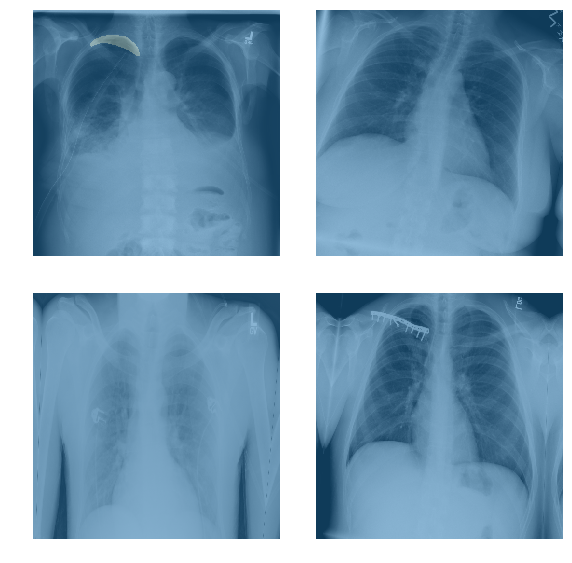

In [79]:
db.show_batch(rows=3, cmap=plt.cm.bone)

In [80]:
clf_name = f'backbone_clf_{MODEL}'
clf_name = f'{clf_name}_{getNextFilePath(MODELS_PATH, clf_name)-1}.pth'
clf_name

'backbone_clf_resnet34_0.pth'

In [109]:
save_name = f'seg_{MODEL}_{TRAIN_SIZE}'
save_name = f'{save_name}_{getNextFilePath(MODELS_PATH, save_name)-1}'
save_name

'seg_resnet34_17'

In [ ]:
#sys.stdout = open('/dev/stdout', 'w')

In [110]:
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                       loss_func=URLoss(CrossEntropyFlat(axis=1)),
                       wd=WD, model_dir=MODELS_PATH, metrics=[soft_dice])

In [83]:
weights = get_weights_sampler(db, beta=0.5)
weights

array([0.5, 0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5, 0.5])

In [84]:
sampler = RandomSampler(len(db.train_ds), weights=torch.tensor(weights))

In [85]:
learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

In [ ]:
#next(learner.model.children())[0].load_state_dict(torch.load(MODELS_PATH/clf_name))

In [ ]:
#learner = learner.to_fp16()

In [86]:
learner = learner.clip_grad(1.)

In [87]:
#learner = learner.load(save_name)

In [ ]:
#learner.lr_find(num_it=1024//BATCH_SIZE)

In [ ]:
#learner.recorder.plot()

In [88]:
LR = 1e-3

In [89]:
set_BN_momentum(learner.model)

In [90]:
date = datetime.datetime.now()

In [91]:
suff = f'_{date.day}-{date.month}-{date.year}_{date.hour}:{date.minute}:{date.second}'
suff

'_7-8-2019_8:54:53'

In [ ]:
#sys.stdout = open('/dev/stdout', 'w')

In [ ]:
learner.fit_one_cycle(
    50, slice(LR),
    callbacks=[
        SaveModelCallback(learner, monitor='valid_loss', name=save_name),
        UpdateSamplerCallback(learner, do_update=False),
        AccumulateStep(learner, 64//BATCH_SIZE),
        LearnerTensorboardWriter(learner, LOG, save_name+suff, loss_iters=10,
                                 hist_iters=100, stats_iters=10)])

epoch,train_loss,valid_loss,soft_dice,time
0,0.014191,0.012972,0.774038,22:59
1,0.012841,0.011319,0.758203,22:00


Better model found at epoch 0 with valid_loss value: 0.012972063384950161.
Better model found at epoch 1 with valid_loss value: 0.011319334618747234.


In [ ]:
#learner.save(save_name)

In [ ]:
#weights = learner.update_sampler_callback.weights

In [ ]:
#learner.recorder.plot_losses()

In [ ]:
#learner.recorder.plot_metrics()

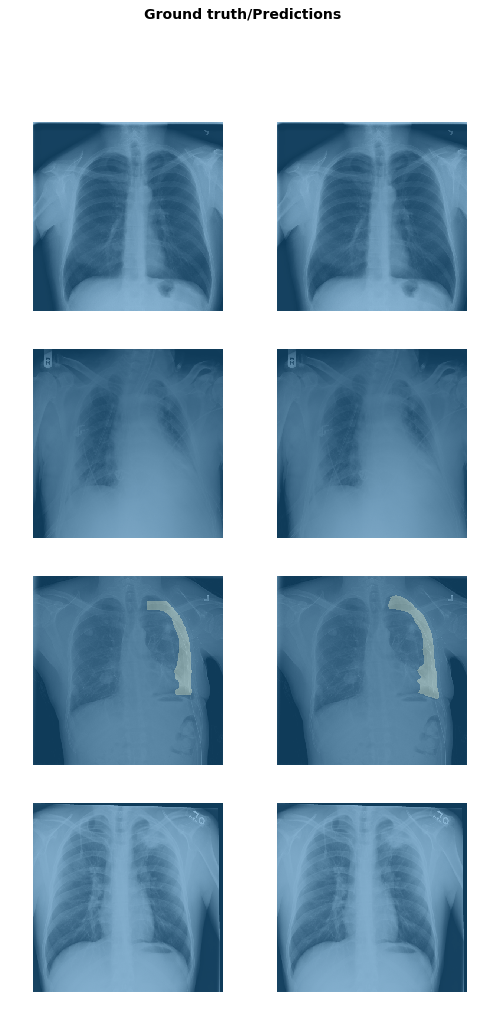

In [92]:
learner.show_results()

In [93]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
learner.data.add_test(test_list, tfms=(), tfm_y=False)

In [94]:
#learner = learner.load(save_name)

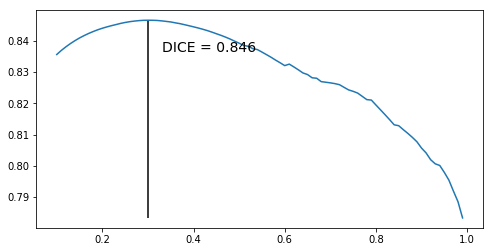

0.29999999999999993

In [97]:
thr = get_best_thr(learner); thr

In [98]:
fn = save_name+'.csv'

In [99]:
sub_df = create_submission(learner, SUB_PATH/fn, thr=thr)

In [100]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "Going vanilla with 2 classes and CE. 512px."

100%|█████████████████████████████████████████| 469k/469k [00:03<00:00, 139kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

### Unfrozen training

In [ ]:
#learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
#                       loss_func=URLoss(BCELoss(beta=0.7)),
#                       wd=WD, model_dir=MODELS_PATH, metrics=[dice])

In [ ]:
#sampler = RandomSampler(len(db.train_ds), weights=torch.tensor(weights))

In [ ]:
#learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

In [ ]:
#learner.load(save_name)

In [111]:
learner.unfreeze()

In [ ]:
#learner.lr_find(num_it=100)

In [ ]:
#learner.recorder.plot(skip_end=1)

In [102]:
LR = 1e-4

In [112]:
uf_save_name = 'uf_'+save_name

In [104]:
#sys.stdout = open('/dev/stdout', 'w')

In [105]:
#weights = [bce_loss(learner.model(x.data.unsqueeze(0).cuda()), y.data.unsqueeze(0).cuda(), beta=0.6).item() for x, y in learner.data.train_ds]

In [106]:
#learner.data.train_dl.sampler.weights = torch.tensor(weights)

In [107]:
learner.fit_one_cycle(
    20, slice(LR),
    callbacks=[
        SaveModelCallback(
            learner, monitor='valid_loss', name=uf_save_name),
        AccumulateStep(learner, 64//BATCH_SIZE),
        LearnerTensorboardWriter(learner, LOG, uf_save_name, loss_iters=20,
                                 hist_iters=100, stats_iters=50)])

epoch,train_loss,valid_loss,soft_dice,time
0,0.006382,0.005810,0.828055,21:17
1,0.005260,0.005681,0.833375,21:08
2,0.005433,0.005650,0.835967,23:54
3,0.005003,0.005721,0.839263,24:40
4,0.005175,0.005895,0.838029,22:15
5,0.005070,0.005654,0.831602,21:47
6,0.003622,0.006070,0.836568,21:30
7,0.004328,0.005950,0.832755,21:15
8,0.006913,0.006333,0.836441,21:26
9,0.005001,0.006472,0.837350,21:25


Better model found at epoch 0 with valid_loss value: 0.0058103385381400585.
Better model found at epoch 1 with valid_loss value: 0.0056808446533977985.
Better model found at epoch 2 with valid_loss value: 0.005650360137224197.


KeyboardInterrupt: 

In [ ]:
#learner.save(uf_save_name)

In [113]:
learner = learner.load(uf_save_name)

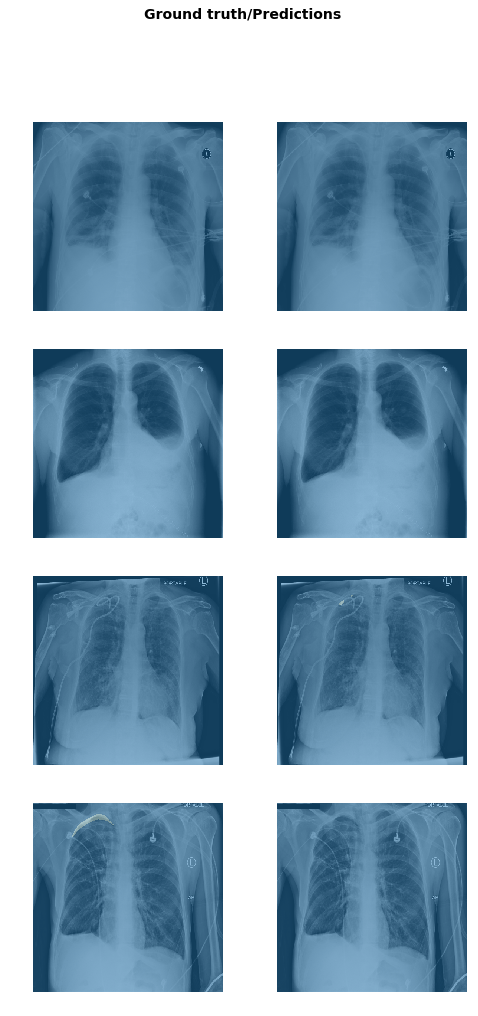

In [125]:
learner.show_results()

In [112]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
learner.data.add_test(test_list, tfms=(), tfm_y=False)

In [124]:
learner.data.label_list.test.tfmargs = {'size': TEST_SIZE}

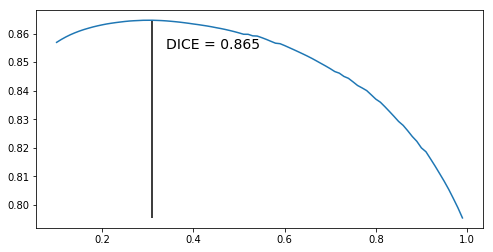

In [126]:
thr = get_best_thr(learner)

In [122]:
fn = uf_save_name+'.csv'

In [126]:
sub_df = create_submission(learner, SUB_PATH/fn, thr=thr)

In [127]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "Going vanilla with 2 classes and CE. Trained on 512px and test on 1024px."

^C
User cancelled operation


### Final training on 1024*1024 images

In [ ]:
fin_save_name = 'fin_'+save_name

In [ ]:
TRAIN_SIZE = 1024
BATCH_SIZE = BATCH_SIZE//4

In [ ]:
db = load_data(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

In [ ]:
learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                       loss_func=URLoss(BCELoss(beta=0.7)),
                       wd=WD, model_dir=MODELS_PATH, metrics=[dice])

In [ ]:
sampler = RandomSampler(len(db.train_ds), weights=torch.tensor(weights))

In [ ]:
learner.data.train_dl = db.train_dl.new(shuffle=False, sampler=sampler)

In [ ]:
learner.load(uf_save_name)

In [ ]:
#learner.clip_grad(10.)

In [ ]:
set_BN_momentum(learner.model)

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(
    10, slice(LR/1e3, LR/50),
    callbacks=[
        SaveModelCallback(
            learner, monitor='dice', name=fin_save_name),
        UpdateSamplerCallback(learner),
        AccumulateStep(learner, 64//BATCH_SIZE),
        LearnerTensorboardWriter(learner, LOG, fin_save_name, loss_iters=10,
                                 hist_iters=100, stats_iters=50)])

In [ ]:
learner.load(fin_save_name)

In [ ]:
learner.data.add_test(test_list, tfms=(), tfm_y=False)

In [ ]:
preds, gt = learner.get_preds(DatasetType.Test)

In [ ]:
if use_sigmoid: preds = torch.sigmoid(preds)

In [ ]:
preds[preds.view(preds.shape[0],-1).sum(-1) < 5e-3*TRAIN_SIZE**2,...] = 0.0

In [ ]:
valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)

In [ ]:
if use_sigmoid: valid_preds = torch.sigmoid(valid_preds)

In [ ]:
valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 5e-3*TRAIN_SIZE**2,...] = 0.0

In [ ]:
thr = get_best_thr(valid_preds, valid_gt)

In [ ]:
fn = fin_save_name+'.csv'

In [ ]:
sub_df = create_submission(db, preds, SUB_PATH/fn, thr=thr)

In [ ]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "bce + new dice where smooth only on denom. "

### K-fold

In [240]:
def load_data_kfold(path, nfolds=5, bs=8, train_size=256):
    kf = KFold(n_splits=nfolds, shuffle=True)
    train_list = (PneumoSegmentationList.
                  from_csv(path.parent, path.name))
    for _, valid_idx in kf.split(np.arange(len(train_list))):
        db = (train_list.
              split_by_idx(valid_idx).
              label_from_df(cols=[0, 1], classes=['pneum'], label_cls=MaskList, train_path=path.parent).
              transform(get_transforms(), size=train_size, tfm_y=True).
              databunch(bs=bs, num_workers=0).
              normalize(imagenet_stats))
        yield db

In [240]:
def predict_k_fold(db, save_name, test_path, nfolds=5, size=256):
    test_list = (PneumoSegmentationList.
                 from_folder(test_path, extensions=['.dcm']))
    db.add_test(test_list, tfms=(), tfm_y=False)
    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                           loss_func=DiceLoss(), wd=WD, model_dir=MODELS_PATH, metrics=[dice])
    learner = learner.to_fp16()
    
    final_preds = torch.zeros((len(test_list), 1, size, size))
    
    for k in range(nfolds):
        learner.load(f'fold{k}_'+save_name)
        
        preds, gt = learner.get_preds(DatasetType.Test)
        preds = torch.sigmoid(preds)
        preds[preds.view(preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0

        valid_preds, valid_gt = learner.get_preds(DatasetType.Valid)
        valid_preds[valid_preds.view(valid_preds.shape[0],-1).sum(-1) < 75.0*4,...] = 0.0
        thr = get_best_thr(valid_preds, valid_gt, plot=False)
        
        final_preds += (preds>thr).float()
    
    final_preds /= nfolds
    sub_df = create_submission(db, final_preds, SUB_PATH/(save_name+'.csv'), thr=0.9)
    return sub_df, final_preds

In [ ]:
best = 0
for k, db in enumerate(load_data_kfold(LABELS_POS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)):
    print(f'fold {k}')
    
    learner = unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                           loss_func=URLoss(BCEDiceLoss(a=0.7, b=0.3)), wd=WD, model_dir=MODELS_PATH, metrics=[dice])
    next(learner.model.children())[0].load_state_dict(torch.load(MODELS_PATH/clf_name))
    learner = learner.to_fp16()
    
    fold_name = f'fold{k}_'+save_name
    learner.fit_one_cycle(
        20, slice(LR),
        callbacks=[
            SaveModelCallback(
                learner, monitor='dice', name=fold_name),
            UpdateSamplerCallback(learner),
            AccumulateStep(learner, 64//BATCH_SIZE)])

    learner.load(fold_name)
    _, met = learner.validate()

    if met > best:
        learner.save(save_name)
        best = met
        print(f'New best fold {k} with dice {best}')
print(best)

fold 2


epoch,train_loss,valid_loss,dice,time


In [241]:
sub_df, preds = predict_k_fold(learner.data, save_name, TEST_PATH, size=TRAIN_SIZE)

In [243]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']))
db = learner.data
db.add_test(test_list, tfms=(), tfm_y=False)
sub_df = create_submission(db, preds, SUB_PATH/('4_'+save_name+'.csv'), thr=0.9)

In [244]:
fn = '4_'+save_name+'.csv'
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "test with resnet34 and k-fold"

100%|█████████████████████████████████████████| 500k/500k [00:04<00:00, 125kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (15 hours from now).


### Classif

In [80]:
CLF_BS = 8*BATCH_SIZE

In [81]:
db_clf = load_data_classif(LABELS_CLASSIF, bs=CLF_BS, train_size=TRAIN_SIZE)

In [82]:
clf = cnn_learner(db_clf, models[MODEL], pretrained=PRETRAINED,
                  wd=WD, model_dir=MODELS_PATH, metrics=[accuracy])

In [144]:
#weights, class_weights = get_weights(db_clf.train_ds)

In [146]:
#sampler = RandomSampler(len(db_clf.train_ds), weights=torch.tensor(weights))

In [147]:
#clf.data.train_dl = db_clf.train_dl.new(shuffle=False, sampler=sampler)

In [83]:
#db_clf.show_batch(cmap=plt.cm.bone)

In [84]:
#clf.load('clf_resnet152_0').to_fp16()

In [85]:
#clf = clf.to_fp16()

In [118]:
save_name = f'clf_{MODEL}_{TRAIN_SIZE}'
save_name = f'{save_name}_{getNextFilePath(MODELS_PATH, save_name)}'
save_name

'clf_resnet34_512_1'

In [87]:
set_BN_momentum(clf.model)

In [88]:
clf = clf.clip_grad(1.)

In [89]:
#clf.lr_find()

In [90]:
#clf.recorder.plot()

In [ ]:
clf.fit_one_cycle(
    20, slice(1e-3),
    callbacks=[
        SaveModelCallback(
            clf, monitor='valid_loss', name=save_name),
        AccumulateStep(clf, 64//CLF_BS),
        LearnerTensorboardWriter(clf, LOG, save_name, loss_iters=5,
                             hist_iters=25, stats_iters=5)])

epoch,train_loss,valid_loss,accuracy,time
0,0.975162,0.629258,0.696019,05:43
1,0.719978,0.451659,0.790164,05:59
2,0.565738,0.461160,0.823419,05:38
3,0.507623,0.433637,0.812178,05:59
4,0.413115,0.391077,0.822482,05:55
5,0.407419,0.382271,0.824356,05:38
6,0.415967,0.374229,0.826698,05:37
7,0.385508,0.357125,0.829508,05:52
8,0.363798,0.362717,0.836534,05:39
9,0.366855,0.346237,0.842623,05:45


Better model found at epoch 0 with valid_loss value: 0.6292577385902405.
Better model found at epoch 1 with valid_loss value: 0.4516586363315582.
Better model found at epoch 3 with valid_loss value: 0.43363726139068604.
Better model found at epoch 4 with valid_loss value: 0.39107653498649597.
Better model found at epoch 5 with valid_loss value: 0.38227105140686035.
Better model found at epoch 6 with valid_loss value: 0.37422892451286316.
Better model found at epoch 7 with valid_loss value: 0.3571248948574066.
Better model found at epoch 9 with valid_loss value: 0.34623655676841736.
Better model found at epoch 12 with valid_loss value: 0.3381406366825104.
Better model found at epoch 13 with valid_loss value: 0.33335617184638977.
Better model found at epoch 17 with valid_loss value: 0.3332216143608093.


In [ ]:
clf.load(save_name)

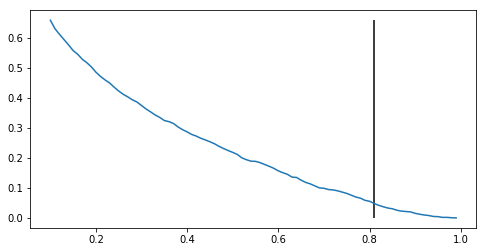

In [168]:
clf_thr = get_best_thr_clf(clf)

In [105]:
test_list = (PneumoClassifList.
             from_folder(TEST_PATH, extensions=['.dcm']))
clf.data.add_test(test_list, tfms=(), tfm_y=False)

In [171]:
preds, gt = clf.get_preds(DatasetType.Test)
preds = preds[:, 1]

In [178]:
idxs = (preds<=clf_thr).nonzero()
ids = test_list.items[idxs].squeeze()

In [179]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']).
             filter_by_func(lambda fn: fn not in ids))
learner.data.add_test(test_list, tfms=(), tfm_y=False)

In [181]:
fn = save_name+'.csv'

In [195]:
#thr = get_best_thr(learner)

In [200]:
sub_df = create_submission_with_clf(learner, SUB_PATH/fn, ids, thr=thr)

In [201]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "Using classifier to filter before unet at test time."

100%|████████████████████████████████████████| 283k/283k [00:03<00:00, 78.5kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

In [202]:
clf.unfreeze()

In [203]:
#clf.lr_find(start_lr=slice(1e-7), end_lr=slice(10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


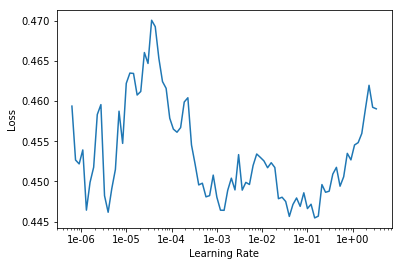

In [204]:
#clf.recorder.plot()

In [119]:
uf_save_name = 'uf_'+save_name

In [ ]:
clf.fit_one_cycle(
    50, slice(1e-4),
    callbacks=[
        SaveModelCallback(
            clf, monitor='valid_loss', name=uf_save_name),
        AccumulateStep(clf, 64//CLF_BS),
        LearnerTensorboardWriter(clf, LOG, uf_save_name, loss_iters=5,
                             hist_iters=25, stats_iters=5)])

epoch,train_loss,valid_loss,accuracy,time
0,0.995613,0.657810,0.698361,06:19
1,0.827072,0.694171,0.673068,05:37
2,0.632443,0.580507,0.716159,06:26
3,0.544368,0.503538,0.746136,05:56
4,0.502834,0.528436,0.743794,05:22
5,0.497792,0.490703,0.758782,05:11
6,0.488112,0.482476,0.772365,05:13


Better model found at epoch 0 with valid_loss value: 0.6578102707862854.
Better model found at epoch 2 with valid_loss value: 0.5805070996284485.
Better model found at epoch 3 with valid_loss value: 0.5035380721092224.
Better model found at epoch 5 with valid_loss value: 0.4907028079032898.
Better model found at epoch 6 with valid_loss value: 0.48247554898262024.


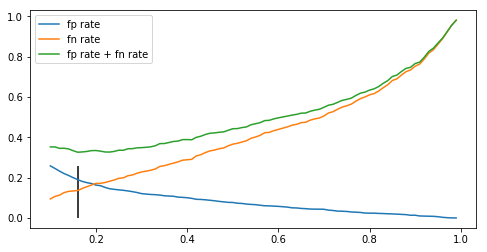

In [101]:
clf_thr = get_best_thr_clf(clf)

In [236]:
test_list = (PneumoClassifList.
             from_folder(TEST_PATH, extensions=['.dcm']))
clf.data.add_test(test_list, tfms=(), tfm_y=False)

In [106]:
preds, gt = clf.get_preds(DatasetType.Test)
preds = preds[:, 1]

In [107]:
idxs = (preds<=clf_thr).nonzero()
ids = test_list.items[idxs].squeeze()

In [127]:
test_list = (PneumoSegmentationList.
             from_folder(TEST_PATH, extensions=['.dcm']).
             filter_by_func(lambda fn: fn not in ids))
learner.data.add_test(test_list, tfms=(), tfm_y=False)

In [128]:
#thr = get_best_thr(learner)

In [129]:
fn = uf_save_name+'.csv'

In [131]:
sub_df = create_submission_with_clf(learner, SUB_PATH/fn, ids, thr=thr)

In [132]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "Using classifier to filter before unet at test time. 512px."

100%|████████████████████████████████████████| 347k/347k [00:05<00:00, 61.0kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

In [102]:
interp = clf.interpret()

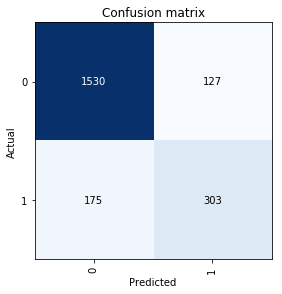

In [103]:
interp.plot_confusion_matrix()

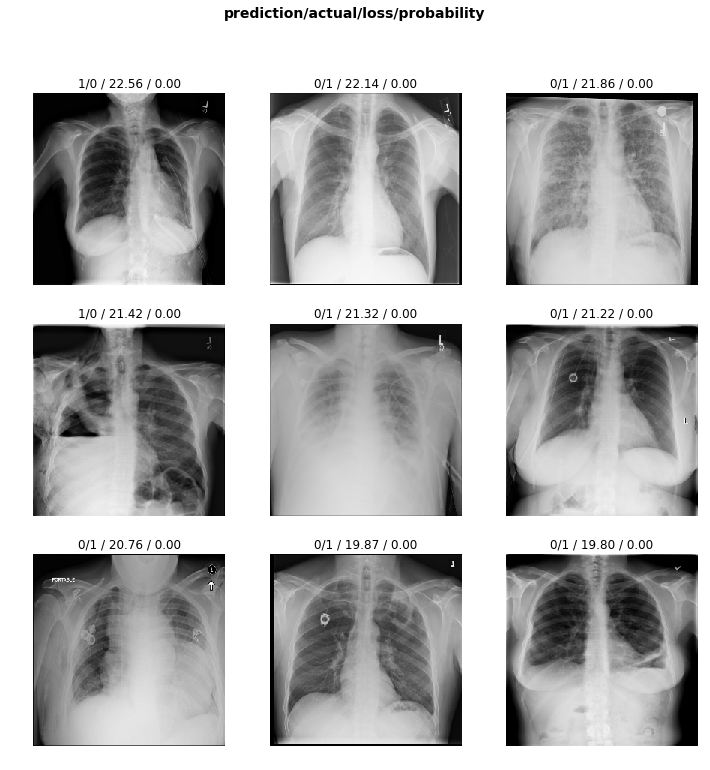

In [214]:
interp.plot_top_losses(9, heatmap=False)

In [268]:
torch.save(next(clf.model.children()).state_dict(), MODELS_PATH/f'backbone_{save_name}.pth')

In [269]:
clf.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [307]:
df = pd.read_csv(LABELS_CLASSIF)
stats = pd.DataFrame(columns=['ImageId', 'Age', 'Sex', 'Height', 'Width', 'Pneumo'])
for row in tqdm(df.itertuples(), total=df.shape[0]):
    fn = row.ImageId
    ds = pydicom.dcmread(str(DATA/fn))
    h, w = ds.pixel_array.shape
    stats.loc[row.Index] = [row.ImageId, int(ds.PatientAge), ds.PatientSex, h, w, int(row.Labels)]

In [308]:
stats.head()

,ImageId,Age,Sex,Height,Width,Pneumo
0,train/1.2.276.0.7230010.3.1.4.8323329.5597.151...,51,F,1024,1024,0
1,train/1.2.276.0.7230010.3.1.4.8323329.12515.15...,17,F,1024,1024,0
2,train/1.2.276.0.7230010.3.1.4.8323329.4904.151...,69,F,1024,1024,1
3,train/1.2.276.0.7230010.3.1.4.8323329.32579.15...,57,F,1024,1024,1
4,train/1.2.276.0.7230010.3.1.4.8323329.1314.151...,16,M,1024,1024,1


In [36]:
stats.loc[stats['Sex']=='F'].shape[0]

4795

In [37]:
stats.loc[stats['Sex']=='M'].shape[0]

5880

In [313]:
stats_age = stats.groupby(pd.cut(stats['Age'], list(range(0, 101, 10))+[450]))

In [39]:
stats_age.count()['Pneumo']

Age
(0, 10]        135
(10, 20]       674
(20, 30]      1266
(30, 40]      1498
(40, 50]      2059
(50, 60]      2606
(60, 70]      1769
(70, 80]       600
(80, 90]        65
(90, 100]        1
(100, 450]       2
Name: Pneumo, dtype: int64

In [309]:
stats_age.sum()['Pneumo']/stats_age.count()['Pneumo']

Age
(0, 10]       0.074074
(10, 20]      0.330861
(20, 30]      0.256714
(30, 40]      0.197597
(40, 50]      0.206897
(50, 60]      0.208749
(60, 70]      0.220464
(70, 80]      0.243333
(80, 90]      0.292308
(90, 100]     0.000000
(100, 450]    0.000000
Name: Pneumo, dtype: float64

In [314]:
stats_sex = stats.groupby('Sex')

In [314]:
stats_sex.count()['Pneumo']

Sex
F    4795
M    5880
Name: Pneumo, dtype: int64

In [313]:
stats_sex.sum()['Pneumo']/stats_sex.count()['Pneumo']

Sex
F    0.219604
M    0.225510
Name: Pneumo, dtype: float64

In [303]:
losses, idxs = interp.top_losses()

In [304]:
idxs = idxs.numpy()

In [305]:
ids = []
for i, l in zip(idxs, losses):
    if l.item()<0.2:
        break
    id = Path(interp.ds.items[i])
    id = Path(id.parent.name)/id.name
    ids.append(str(id))

In [309]:
top_losses = stats.loc[stats['ImageId'].isin(ids)]

In [310]:
top_losses.head()

,ImageId,Age,Sex,Height,Width,Pneumo
7,train/1.2.276.0.7230010.3.1.4.8323329.4440.151...,65,F,1024,1024,1
44,train/1.2.276.0.7230010.3.1.4.8323329.13361.15...,52,F,1024,1024,1
52,train/1.2.276.0.7230010.3.1.4.8323329.14508.15...,21,M,1024,1024,1
70,train/1.2.276.0.7230010.3.1.4.8323329.4333.151...,58,M,1024,1024,1
79,train/1.2.276.0.7230010.3.1.4.8323329.3140.151...,62,F,1024,1024,1


In [311]:
top_losses.groupby('Pneumo').count().head()['ImageId']

Pneumo
0     73
1    191
Name: ImageId, dtype: int64

In [315]:
top_losses.groupby('Sex').count().head()['ImageId']/stats_sex.count()['Pneumo']

Sex
F    0.022941
M    0.026190
dtype: float64

In [316]:
top_losses.groupby(pd.cut(top_losses['Age'], list(range(0, 101, 10))+[450])).count().head()['ImageId']/stats_age.count()['Pneumo']

Age
(0, 10]       0.022222
(10, 20]      0.025223
(20, 30]      0.033175
(30, 40]      0.022029
(40, 50]      0.019427
(50, 60]           NaN
(60, 70]           NaN
(70, 80]           NaN
(80, 90]           NaN
(90, 100]          NaN
(100, 450]         NaN
dtype: float64

In [112]:
dl = clf.data.train_dl

In [167]:
from itertools import tee
def new_iter(self):
    dl = iter(self.dl)
    dl.sample_iter, self.sample_iter = tee(dl.sample_iter)
    for b in dl:
        yield self.proc_batch(b)

In [168]:
from fastai.basic_data import DeviceDataLoader
DeviceDataLoader.__iter__= new_iter

In [208]:
idxs = []
xs = []
for x in tqdm(dl, total=len(dl)):
    idxs.append(next(dl.sample_iter))
    xs.append(x)

False



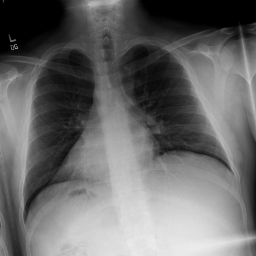

In [220]:
clf.data.train_ds[idxs[2][0]][0]

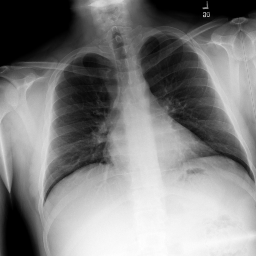

In [221]:
x = xs[2][0][0].float()
Image((x-torch.min(x))/(torch.max(x)-torch.min(x)))

### MultiTask Learning

In [85]:
db = load_data_mtl(LABELS, bs=BATCH_SIZE, train_size=TRAIN_SIZE)

In [377]:
#db.show_batch()

In [378]:
seg_loss = DiceLoss()

In [87]:
learner = multi_task_unet_learner(db, models[MODEL], pretrained=PRETRAINED,
                       loss_func=MTLLoss(CrossEntropyFlat(), CrossEntropyFlat(axis=1)),
                       wd=WD, model_dir=MODELS_PATH, metrics=[mtl_metric(dice, dim=1),
                                                              mtl_metric(accuracy, dim=0),
                                                              average_mtl_metric([dice, accuracy], [1, 0])])

In [88]:
save_name = f'mtl_{MODEL}_{TRAIN_SIZE}'
save_name = f'{save_name}_{getNextFilePath(MODELS_PATH, save_name)-3}'
save_name

'mtl_resnet34_512_2'

In [98]:
prev_save_name = f'mtl_{MODEL}_{512}'
prev_save_name = f'{prev_save_name}_{getNextFilePath(MODELS_PATH, prev_save_name)-1}'
prev_save_name = 'uf_fold2_mtl_resnet34_256_2'
prev_save_name

'uf_fold2_mtl_resnet34_256_2'

In [99]:
learner.load(prev_save_name)

Learner(data=DataBunch;

Train: LabelList (8540 items)
x: MultiTaskList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiTaskLabelList
Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512)
Path: /work/stages/schwob/siim-pneumothorax/data;

Valid: LabelList (2135 items)
x: MultiTaskList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiTaskLabelList
Category pneum; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512)
Path: /work/stages/schwob/siim-pneumothorax/data;

Test: None, model=MultiTaskModel(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(

In [100]:
learner.model.log_vars.val

Parameter containing:
tensor([-0.8084, -3.5865], device='cuda:0', requires_grad=True)

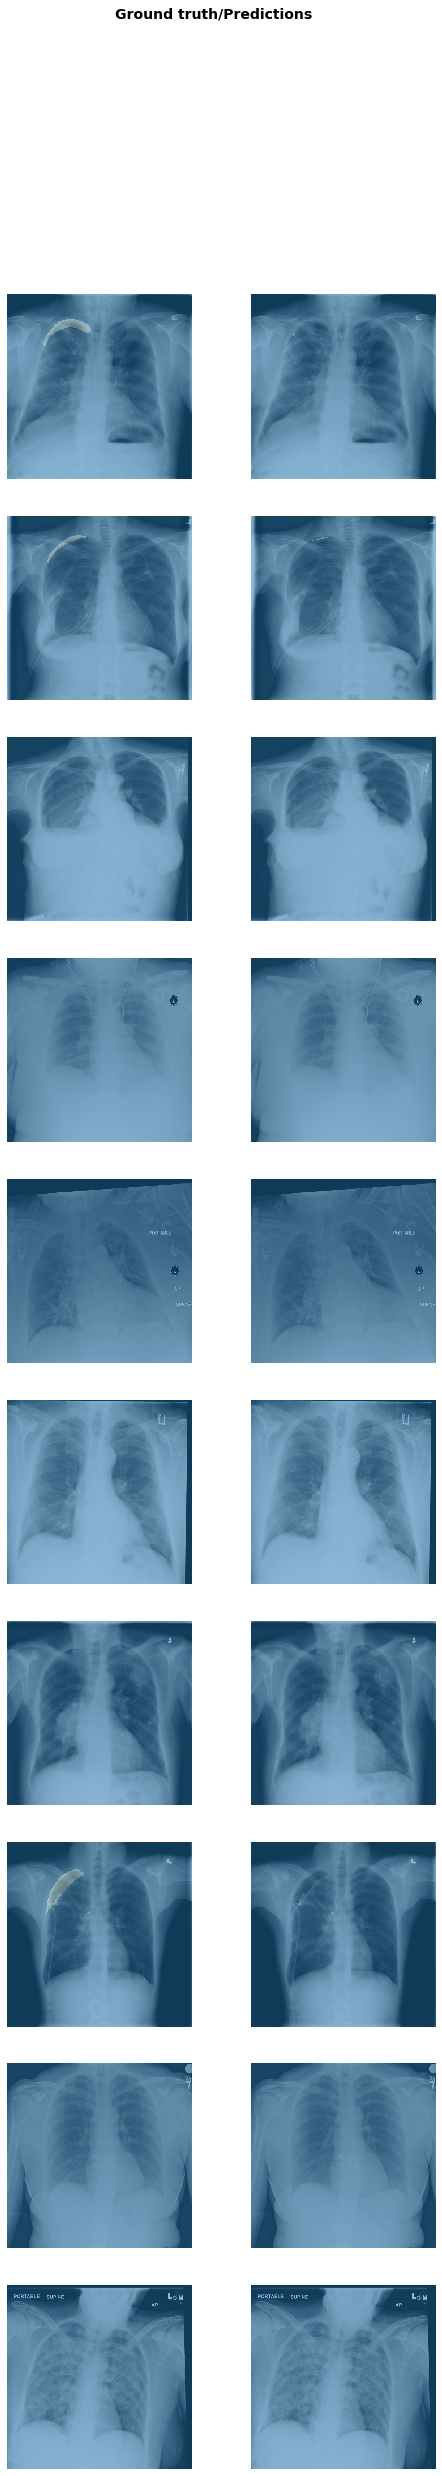

In [101]:
learner.show_results(rows=10)

In [90]:
#learner = learner.clip_grad(1.)

In [91]:
set_BN_momentum(learner.model)

In [92]:
#learner.lr_find(num_it=1024//BATCH_SIZE)

In [93]:
#learner.recorder.plot()

In [94]:
LR = 1e-5

In [95]:
date = datetime.datetime.now()

In [96]:
suff = f'_{date.day}-{date.month}-{date.year}_{date.hour}:{date.minute}:{date.second}'
suff

'_16-8-2019_15:5:41'

In [97]:
#sys.stdout = open('/dev/stdout', 'w')

In [ ]:
project = neptune.init('schwobr/SIIM-Pneumothorax')

In [98]:
learner.fit_one_cycle(
    1, slice(LR), wd=1e-4,
    callbacks=[
        SaveModelCallback(learner, monitor='dice', name=save_name),
        MTLLossCallback(learner),
        AccumulateStep(learner, 64//BATCH_SIZE),
        NeptuneCallback(learner, project, name=save_name, params={'lr': LR, 'wd': WD, 'size':TRAIN_SIZE}),
        LearnerTensorboardWriter(learner, LOG, save_name+suff, loss_iters=10,
                                 hist_iters=50, stats_iters=10)])

psutil is not installed. The experiment will not be abortable.
psutil is not installed. The experiment will not be abortable.
psutil is not installed. Hardware metrics will not be collected.


SIIM-2
https://ui.neptune.ml/schwobr/SIIM-Pneumothorax/e/SIIM-2


epoch,train_loss,valid_loss,dice,accuracy,dice_accuracy,time
0,0.156807,-0.217788,0.887818,0.829040,0.858429,44:03


Better model found at epoch 0 with dice value: 0.8878178000450134.


In [ ]:
learner.unfreeze()

In [382]:
uf_save_name = 'uf_'+save_name

In [ ]:
LR = 5e-5

In [135]:
learner.fit_one_cycle(
    20, slice(LR/100, LR), wd=1e-4,
    callbacks=[
        SaveModelCallback(learner, monitor='dice', name=uf_save_name),
        MTLLossCallback(learner),
        AccumulateStep(learner, 64//BATCH_SIZE),
        NeptuneCallback(learner, project, name=save_name, params={'lr': LR, 'wd': WD, 'size':TRAIN_SIZE})
        LearnerTensorboardWriter(learner, LOG, uf_save_name, loss_iters=10,
                                 hist_iters=50, stats_iters=10)])

AttributeError: 'Learner' object has no attribute 'fit_one_cycle'

In [384]:
learner.load(uf_save_name)

Learner(data=DataBunch;

Train: LabelList (8540 items)
x: MultiTaskList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiTaskLabelList
Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512)
Path: /work/stages/schwob/siim-pneumothorax/data;

Valid: LabelList (2135 items)
x: MultiTaskList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiTaskLabelList
Category bg; ImageSegment (1, 512, 512),Category pneum; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512),Category bg; ImageSegment (1, 512, 512)
Path: /work/stages/schwob/siim-pneumothorax/data;

Test: None, model=MultiTaskModel(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(

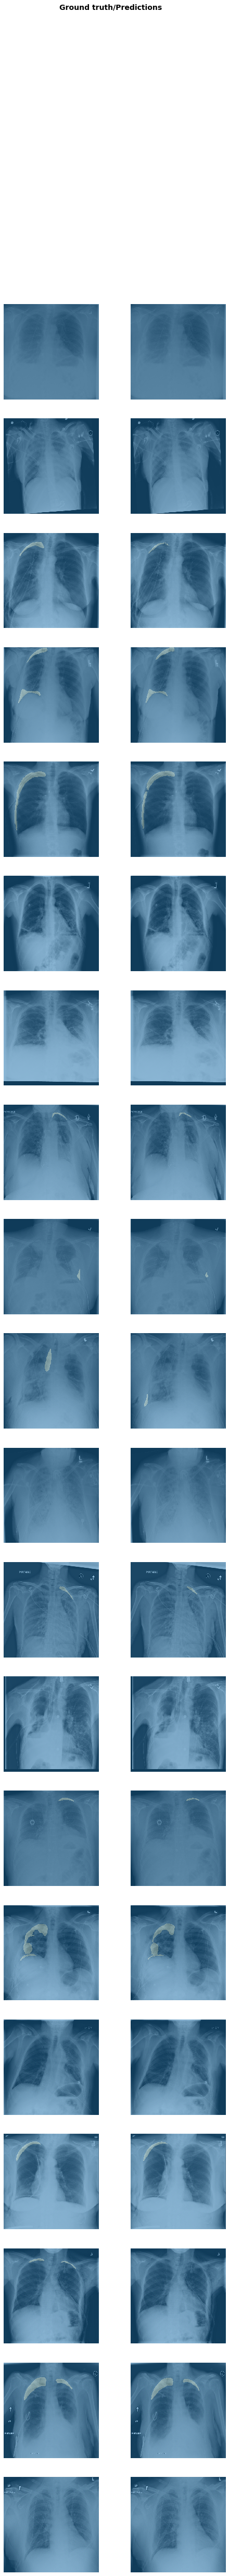

In [385]:
learner.show_results(ds_type=2, rows=20)

In [386]:
test_list = (MultiTaskList.
             from_folder(TEST_PATH, extensions=['.dcm']))
learner.data.add_test(test_list, label=[test_list.items[0], '-1'], tfms=(), tfm_y=True)

In [387]:
#learner.data.label_list.test.tfmargs = {'size': TEST_SIZE}

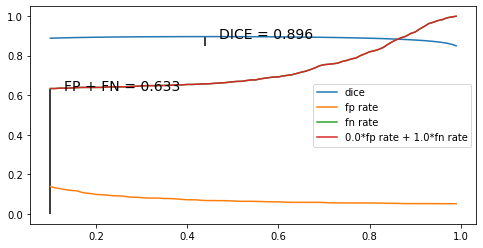

In [393]:
thr, thr_clf = get_best_thrs_mtl(learner, a=0.)

In [407]:
fn = '11_'+uf_save_name+'.csv'

In [408]:
sub_df = create_submission_mtl(learner, SUB_PATH/fn, thr=thr, thr_clf=0.)

In [409]:
sub_df.loc[sub_df['EncodedPixels'] != '-1'].shape

(236, 2)

In [410]:
!kaggle competitions submit -c siim-acr-pneumothorax-segmentation -f ../submissions/$fn -m "Thresholding before resize. No clf thr. Higher threshold to delete small masks"

100%|████████████████████████████████████████| 397k/397k [00:04<00:00, 83.1kB/s]
Successfully submitted to SIIM-ACR Pneumothorax Segmentation

In [129]:
df1 = pd.read_csv(SUB_PATH/fn)
df2 = pd.read_csv(SUB_PATH/'4_uf_mtl_resnet34_256_1.csv')
df3 = pd.read_csv(SUB_PATH/'uf_clf_resnet34_512_1.csv')

In [117]:
df = df1.append(df2, ignore_index=True)

In [119]:
df = df.append(df3, ignore_index=True)

In [125]:
merge_doubles(SUB_PATH/'merge_test.csv', SUB_PATH/'merge_test.csv')

AttributeError: 'float' object has no attribute 'split'

In [103]:
def show_preds(csv_path, test_path, idxs, bs=8):
    df = pd.read_csv(csv_path)
    df.to_csv(test_path/csv_path.name, index=False)
    db = (PneumoSegmentationList.
                 from_csv(test_path, csv_path.name).
                 split_none().
                 label_from_df(cols=[0, 1], classes=['bg', 'pneum'], label_cls=SoftmaxMaskList, train_path=test_path).
                 databunch(bs=bs, num_workers=0))
    db.show_batch(rows=bs)
    return db